In [1]:
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from multiprocessing import Pool
from utils import (
    prepare_arrival_events_from_real_data,
    run_all_simulations_for_seed,
)
from constants import taxi_type

# ⚙️ Simulation Configuration

Define key parameters for the simulation:
- `Delta`: length of time blocks in minutes
- `max_time`: total simulation duration (hours)
- `N`: number of taxis in the fleet
- `eta`: hyperparameter for JLCR policy
- `lookahead_options`: defines which Q-matrix files (for lookahead) to use in some modes

In [2]:
Delta = 20  # in minutes
max_time = 24  # hours
N = 8000
start_time = pd.Timestamp("2025-01-02 08:00:00")
eta = 0.5
lookahead_options = [2, 4, 8]

# 📊 Load Demand and Travel Parameters

This block loads:
- `trip_counts`: counts of trips for computing λ and P
- `mu_`: average travel rates
It computes:
- `lambda_`: arrival rate by region and time
- `P`: destination distribution by region and time
Also initializes `Q_base`, which encodes no relocation (identity matrix).

In [3]:
with np.load("../nyc_trip/trip_counts.npz") as data:
    trip_counts = data["trip_counts"]
    num_dates = data["num_dates"]

with np.load('../nyc_trip/mu_cp_clipped.npz') as data:
    mu = data['mu']

trip_counts[trip_counts == 0] = 1
lambda_ = trip_counts.sum(axis=2) / (Delta / 60 * num_dates)
P = trip_counts / trip_counts.sum(axis=2, keepdims=True)

T, R, _ = P.shape
Q_base = np.array([np.identity(R) for _ in range(T)])

# read Q_matrix file
with np.load('../nyc_trip/Q_clipping.npz') as data:
    Q = data['Q']

# 🚖 Load Observed Demand Data

This block loads the real NYC trip data:
- It finds one file based on `taxi_type`
- It extracts 3 consecutive weekdays of trips using `prepare_arrival_events_from_real_data()`
These trips are later used for the real-demand simulation mode.

Change data_dir where you saved the parquet file. They should look like: `fhv_tripdata_2023-01.parquet`. If you don't have one, download one [here](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [4]:
data_dir = "../nyc_trip/data"
filenames = os.listdir(data_dir)
filenames = [fn for fn in filenames if fn.startswith(taxi_type)]
file = filenames[0]

df = pd.read_parquet(f"../nyc_trip/data/{file}")
arrival_events = prepare_arrival_events_from_real_data(df)

In [5]:
from relocation_policies import relocation_policy_blind_sampling
from simulate import TaxiSimulator
from utils import (
    get_ridestarts_timeseries,
    get_rider_arrival_timeseries,
    get_rider_lost_timeseries,
    fill_missing_time_bins
)

In [6]:
Qs = np.array(Q for _ in range(T))
# Setup relocation policy
policy = relocation_policy_blind_sampling
kwargs = {}
# Init simulator

sim = TaxiSimulator(
    T=T,
    R=R,
    N=N,
    lambda_=lambda_,
    mu_=mu,
    P=P,
    Q=Qs,
    relocation_policy=policy,
    relocation_kwargs=kwargs,
    use_real_demand=True,
    demand_events=arrival_events if True else None,
)

# Run sim
sim.run(max_time=max_time)
df_log = pd.DataFrame(sim.logger)

In [7]:
df_log['datetime'] = pd.to_timedelta(df_log['time'], unit='h') + pd.Timestamp('2025-01-02')

In [17]:
from datetime import timedelta
import matplotlib.pyplot as plt
from constants import (
    RIDER_ARRIVAL,
    RIDE_START,
    RIDER_LOST,
)

In [26]:
region_id = 12
arrivals = df_log[df_log['event_type'] == RIDER_ARRIVAL].copy()
arrivals['region'] = arrivals['data'].apply(lambda x: x['region'])
arrivals = arrivals[arrivals['region'] == region_id]
arrivals['time_bin'] = arrivals['datetime'].dt.floor(f'{bin_minutes}min')
arrival_counts = arrivals.groupby('time_bin').size().reset_index(name='num_arrivals')

In [36]:
ride_starts = df_log[df_log['event_type'] == RIDE_START].copy()
# ride_starts['region'] = ride_starts['data'].apply(lambda x: x['origin'])
# ride_starts = ride_starts[ride_starts['region'] == region_id]

# ride_starts['time_bin'] = ride_starts['datetime'].dt.floor(f'{bin_minutes}min')
# ride_starts = ride_starts.groupby('time_bin').size().reset_index(name='num_ridestarts')
ride_starts

,time,event_type,data,datetime


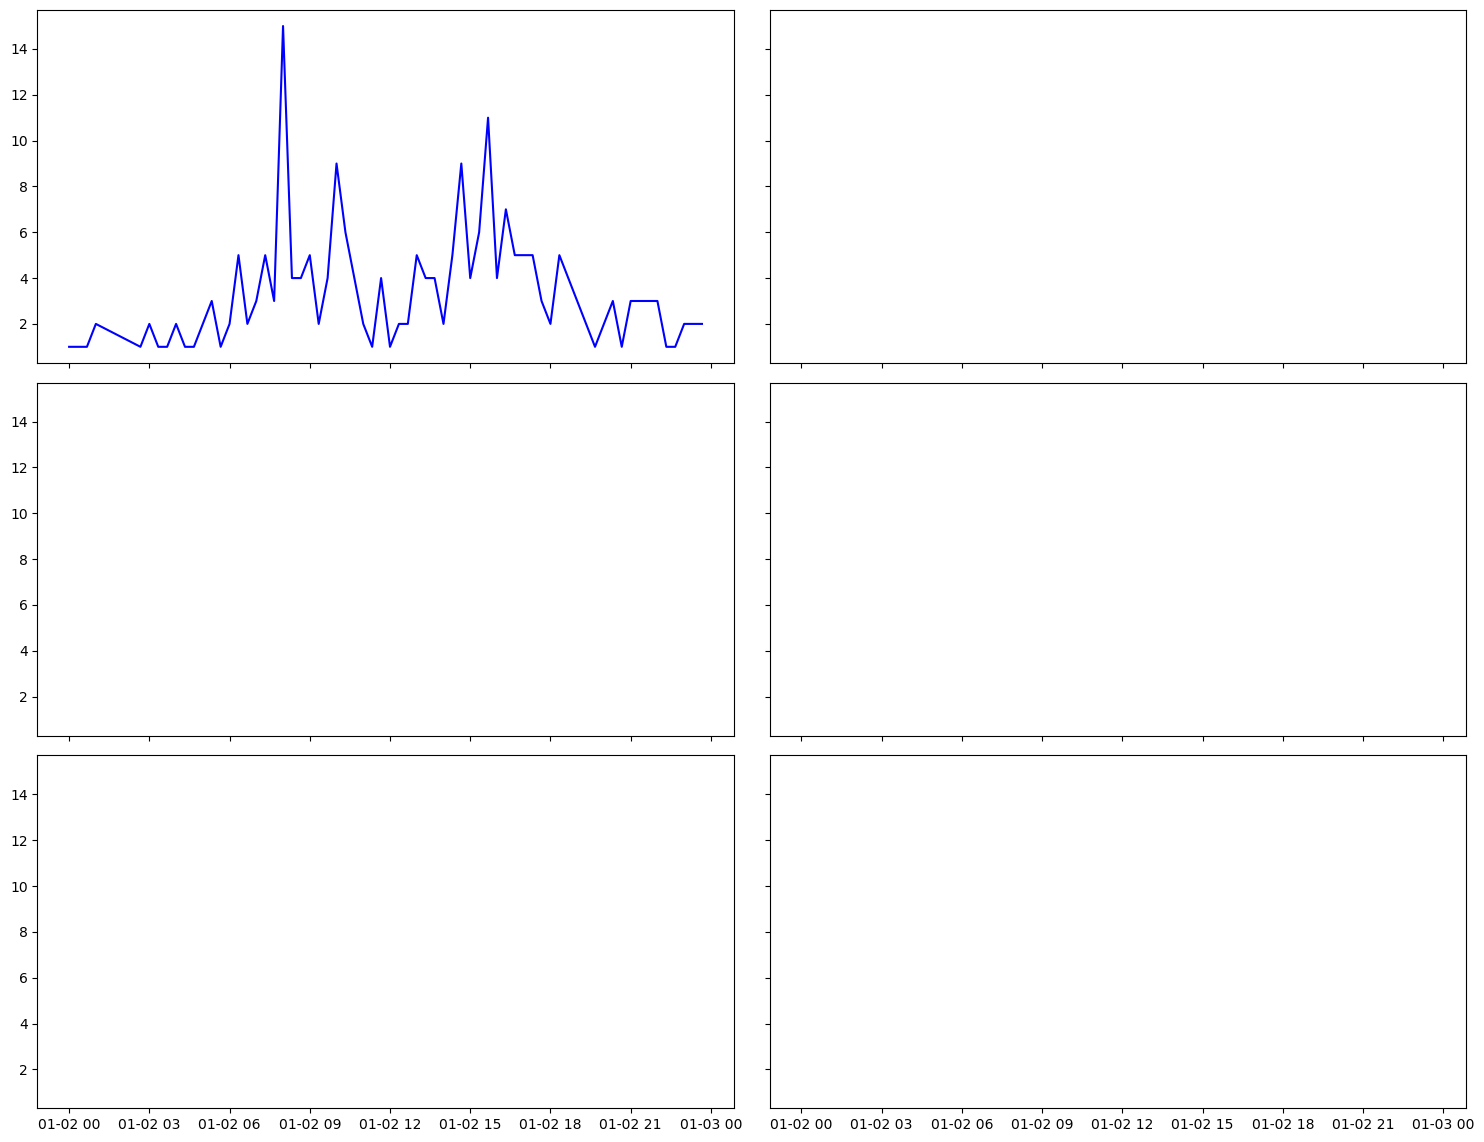

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

region_id =  14
bin_minutes = 20

arrival_ts = get_rider_arrival_timeseries(df_log, region_id=region_id, bin_minutes=bin_minutes)
ridestarts_ts = get_ridestarts_timeseries(df_log, region_id=region_id, bin_minutes=bin_minutes)
lostrides_ts = get_rider_lost_timeseries(df_log, region_id=region_id, bin_minutes=bin_minutes)

start_time = arrival_ts['time_bin'].min() + timedelta(days=2)
end_time = arrival_ts['time_bin'].max()

# arrival_ts = fill_missing_time_bins(arrival_ts, start_time, end_time, bin_minutes, count_col='num_arrivals')
# ridestarts_ts = fill_missing_time_bins(ridestarts_ts, start_time, end_time, bin_minutes, count_col='num_ridestarts')
# lostrides_ts = fill_missing_time_bins(lostrides_ts, start_time, end_time, bin_minutes, count_col='num_lost_rides')

ax = axes[0]
ax.plot(arrival_ts['time_bin'], arrival_ts['num_arrivals'], label='Arrivals', color='blue')
ax.plot(ridestarts_ts['time_bin'], ridestarts_ts['num_ridestarts'], label='Ride Starts', color='orange')
ax.plot(lostrides_ts['time_bin'], lostrides_ts['num_lost_rides'], label='Lost Riders', color='purple')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 🚀 Run Simulations in Parallel

This block launches simulations across 20 seeds using multiprocessing.
Each call to `run_all_simulations_for_seed(...)` will:
- Run 12 simulation modes (2 demand × 6 relocation)
- Save each resulting log under `sim_outputs/{seed}/...`
The total of 240 runs (20×12) are processed in parallel using a 6-core pool.


In [ ]:
# Launch multiprocessing pool
num_repeats = 20
args = [
    (
        seed,
        lambda_, mu_, P, Q_base, arrival_events,
        T, R, N, max_time
    )
    for seed in range(num_repeats)
]

with Pool(processes=6) as pool:
    for _ in tqdm(pool.starmap(run_all_simulations_for_seed, args), total=len(args)):
        pass
